In [115]:
loss = torch.nn.BCEWithLogitsLoss(reduce=False)
a,b,c,d=data_tup_to_tensors(adobe_data)
out = []
for aa,bb,cc,dd in zip(a,b,c,d):
    out.append(loss(cc, bb).data.numpy().tolist())
adobe_data[3] = out
json.dump(adobe_data, open('/home/yuhuiz/Transformer/abstention/adobe_data_right.json', 'w'))

## Learn to Reject Vol 2.

This is a cleaned-up version of first version.

Investigate:
1. h, pred (before and after sigmoid), conf to predict loss
2. h, pred (before and after sigmoid), conf, to predict accuracy (instance-level)
3. A function that returns prediction/true value pairs, so we can make scatter plot and compute R^2
4. WGAN

In [116]:
import torch
import json

gpu_id = 0

In [117]:
with open('/home/yuhuiz/Transformer/abstention/valid_data_right.json', 'rb') as f:
    valid_data = json.load(f)

In [118]:
with open('/home/yuhuiz/Transformer/abstention/test_data_right.json', 'rb') as f:
    test_data = json.load(f)

In [119]:
with open('/home/yuhuiz/Transformer/abstention/train_data_right.json', 'rb') as f:
    train_data = json.load(f)

In [120]:
with open('/home/yuhuiz/Transformer/abstention/adobe_data_right.json', 'rb') as f:
    adobe_data = json.load(f)

In [150]:
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
%matplotlib inline 

In [151]:
import numpy as np
from torch.autograd import Variable

def list_to_tensor(ls, to_var=True, requires_grad=False):
    tensor_iter_list = []
    for l in ls:
        t = torch.from_numpy(np.array(l, dtype='float32'))
        if to_var:
            t = Variable(t, requires_grad=requires_grad)
        # we only move to cuda as necessary
        tensor_iter_list.append(t)
    return tensor_iter_list

def data_tup_to_tensors(data):
    a,b,c,d = data
    return list_to_tensor(a), list_to_tensor(b), list_to_tensor(c), list_to_tensor(d)

In [152]:
batched_x_list, batched_y_list, batched_y_hat_list, batched_loss_list = train_data
batched_valid_x_list, batched_valid_y_list, batched_valid_y_hat_list, batched_valid_loss_list = valid_data
batched_test_x_list, batched_test_y_list, batched_test_y_hat_list, batched_test_loss_list = test_data
batched_adobe_x_list, batched_adobe_y_list, batched_adobe_y_hat_list, batched_adobe_loss_list= adobe_data

In [153]:
batched_x_tensor_list = list_to_tensor(batched_x_list)
batched_y_tensor_list = list_to_tensor(batched_y_list)
batched_y_hat_tensor_list = list_to_tensor(batched_y_hat_list)
batched_loss_tensor_list = list_to_tensor(batched_loss_list)

In [154]:
batched_valid_x_tensor_list = list_to_tensor(batched_valid_x_list)
batched_valid_y_tensor_list = list_to_tensor(batched_valid_y_list)
batched_valid_y_hat_tensor_list = list_to_tensor(batched_valid_y_hat_list)
batched_valid_loss_tensor_list = list_to_tensor(batched_valid_loss_list)

In [155]:
batched_test_x_tensor_list = list_to_tensor(batched_test_x_list)
batched_test_y_tensor_list = list_to_tensor(batched_test_y_list)
batched_test_y_hat_tensor_list = list_to_tensor(batched_test_y_hat_list)
batched_test_loss_tensor_list = list_to_tensor(batched_test_loss_list)

In [156]:
batched_adobe_x_tensor_list = list_to_tensor(batched_adobe_x_list)
batched_adobe_y_tensor_list = list_to_tensor(batched_adobe_y_list)
batched_adobe_y_hat_tensor_list = list_to_tensor(batched_adobe_y_hat_list)
batched_adobe_loss_tensor_list = list_to_tensor(batched_adobe_loss_list)

(array([  18.,  338.,  994., 1610., 1811., 1626., 1344.,  954.,  632.,
         361.]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ]),
 <a list of 10 Patch objects>)

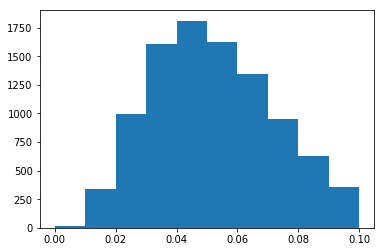

In [157]:
example_based_loss = [np.mean(b) for b in train_data[-1]]
plt.hist(example_based_loss, range=[0, 0.1])

(array([ 1.,  6., 31., 51., 62., 84., 71., 79., 62., 43.]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ]),
 <a list of 10 Patch objects>)

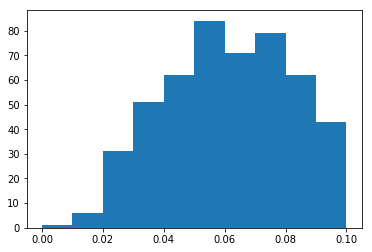

In [158]:
example_based_loss = [np.mean(b) for b in valid_data[-1]]
plt.hist(example_based_loss, range=[0, 0.1])

(array([ 0.,  6., 21., 53., 74., 93., 69., 69., 46., 38.]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ]),
 <a list of 10 Patch objects>)

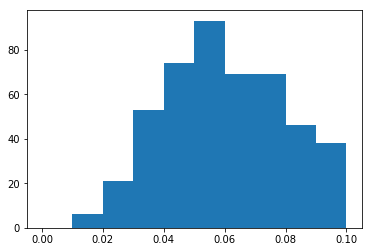

In [159]:
example_based_loss = [np.mean(b) for b in test_data[-1]]
plt.hist(example_based_loss, range=[0, 0.1])

In [160]:
class Config(object):
    def __init__(self, obj_loss=False, obj_accu=False, 
                 inp_logit=False, inp_pred=False,
                 inp_h=False, train_on_val=False,
                train_on_train=False, inp_conf=False,
                clip_grad=5., no_shrink=True, reduce_loss=False):
        
        # some logic checks
        assert inp_logit + inp_pred + inp_h + inp_conf == 1, "only one input type"
        assert obj_loss + obj_accu == 1, "only one objective type"
        assert train_on_train or train_on_val, "only one training scheme"
        
        self.hparams = {
            'obj_loss': obj_loss,  # objective is loss
            'obj_accu': obj_accu,  # objective is accu
            'inp_logit': inp_logit, # input is logit (before sigmoid)
            'inp_pred': inp_pred, # input is pred (after sigmoid)
            'inp_h': inp_h,
            'inp_conf': inp_conf,
            'train_on_val': train_on_val,
            'train_on_train': train_on_train,
            'clip_grad': clip_grad,
            'no_shrink': no_shrink,
            'reduce_loss': reduce_loss
        }
    
    def __getitem__(self, key):
        return self.hparams[key]

    def __setitem__(self, key, value):
        self.hparams[key] = value

In [161]:
len(batched_test_x_list[0][0])

3072

In [162]:
import torch.nn as nn
class Reject_Model(nn.Module):
    def __init__(self, config):
        super(Reject_Model, self).__init__()
        if config['inp_h']:
            reject_dim = len(batched_test_x_list[0][0])
        else:
            reject_dim = len(batched_test_y_list[0][0])
        
        if config['no_shrink']:
            self.reject_model = nn.Sequential(
                    nn.Linear(reject_dim, int(reject_dim)),
                    nn.SELU(),
                    nn.Linear(int(reject_dim), int(reject_dim)),
                    nn.SELU(),
                    nn.Linear(int(reject_dim), 1))            
        else:
            self.reject_model = nn.Sequential(
                    nn.Linear(reject_dim, int(reject_dim / 2.)),
                    nn.SELU(),
                    nn.Linear(int(reject_dim / 2.), int(reject_dim / 4.)),
                    nn.SELU(),
                    nn.Linear(int(reject_dim / 4.), 1))

    def pred(self, x):
        return self.reject_model(x)
        
    def reject(self, x, gamma=0.):
        # x: (batch_size, rej_dim)
        rej_choices = self.reject_model(x) > gamma
        return rej_choices

In [163]:
import math
from sklearn import metrics

mse_loss = torch.nn.MSELoss()
sigmoid = torch.nn.Sigmoid()

def prob_of_success(prob):
    if prob >= 0.5:
        return prob  # confidence in positive label
    else:
        return 1 - prob
    
def py_sigmoid(x):
    return 1 / (1 + math.exp(-x))

def batched_y_hat_to_prob(b_y_hat):
    return list(map(lambda x: [py_sigmoid(x_bar) for x_bar in x], b_y_hat))

def batched_y_hat_to_pred(b_y_hat):
    return (np.array(list(map(lambda x: [py_sigmoid(x_bar) for x_bar in x], b_y_hat)), dtype=np.float32) > 0.5).astype(float)

def loss_train(reject_model, optimizer, config, print_log=False):
    exp_cost = None
    iteration = 0
    loss_list = []
    exp_loss_list = []
    
    # predicted objective and true objective pair (for scatterplot)
    obj_pred_true_pairs = []
    
    reject_model.train()

    if config['train_on_train']:
        data_tup = zip(batched_x_tensor_list, batched_y_list, batched_y_hat_list, batched_loss_tensor_list)
    elif config['train_on_val']:
        data_tup = zip(batched_valid_x_tensor_list, batched_valid_y_list, 
                        batched_valid_y_hat_list, batched_valid_loss_tensor_list)
        
    for x, y, y_hat, orig_loss in data_tup:
        reject_model.zero_grad()
        
        inp = None
        # input preprocessing
        if config['inp_logit']:
            inp = Variable(torch.FloatTensor(y_hat)).cuda(gpu_id)
        elif config['inp_pred']:
            inp = Variable(torch.FloatTensor(list(map(lambda x: [py_sigmoid(x_bar) for x_bar in x], y_hat)))).cuda(gpu_id)
        elif config['inp_h']:
            inp = x.cuda(gpu_id)
        elif config['inp_conf']:
            inp = Variable(torch.FloatTensor(list(map(lambda x: [prob_of_success(py_sigmoid(x_bar)) for x_bar in x], y_hat)))).cuda(gpu_id)
        
        pred_obj = torch.squeeze(reject_model.pred(inp), 1)
        
        # objective preprocessing
        
        if config['obj_loss']:
            true_obj = orig_loss.cuda(gpu_id).mean(dim=1)
        elif config['obj_accu']:
            preds = batched_y_hat_to_pred(y_hat)  # turn logit to one-hot predictions, numpy array
            true_obj = []
            for i, y_inst in enumerate(y):
                true_obj.append(metrics.accuracy_score(np.array(y_inst), preds[i]))
            true_obj = Variable(torch.FloatTensor(true_obj)).cuda(gpu_id)
        
        # compute loss
        # we do MMSE loss

        loss = mse_loss(pred_obj, true_obj)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm(reject_model.parameters(), config['clip_grad'])
        optimizer.step()
        
        # add pairs for scatter plot
        obj_pred_true_pairs.extend(zip(true_obj.data.cpu().numpy().tolist(), pred_obj.data.cpu().numpy().tolist()))
        
        if not exp_cost:
            exp_cost = loss.data[0]
        else:
            exp_cost = 0.99 * exp_cost + 0.01 * loss.data[0]
        
        if iteration % 100 == 0 and print_log:
            # avg_rej_rate = rej_scores.mean().data[0]
            print("iter {} lr={} train_loss={} exp_cost={} \n".format(iteration,
                                                                    optimizer.param_groups[0]['lr'],
                                                                    loss.data[0], exp_cost))        
        loss_list.append(loss.data[0])
        exp_loss_list.append(exp_cost)
        
        iteration += 1
        
    return loss_list, exp_loss_list, obj_pred_true_pairs

In [164]:
def loss_train_epochs(epochs, reject_model, optimizer, config, print_log=False):
    all_loss_list = []
    all_exp_loss_list = []
    
    for n in range(epochs):
        loss_list, exp_loss_list, obj_pred_true_pairs = loss_train(reject_model, optimizer,config, print_log=print_log)

        all_loss_list.extend(loss_list)
        all_exp_loss_list.extend(exp_loss_list)
        
        print("Epoch {} finished".format(n + 1))
        
    return all_loss_list, all_exp_loss_list, obj_pred_true_pairs

In [165]:
import torch.optim as optim

def loss_reset_all(config, lr=0.001):
    # use this function to get a fresh model and fresh optimizer
    need_grad = lambda x: x.requires_grad

    reject_model = Reject_Model(config)

    if gpu_id != -1:
        reject_model.cuda(gpu_id)

    rej_optimizer = optim.Adam(filter(need_grad, reject_model.parameters()),
                                       lr=lr)
    
    return reject_model, rej_optimizer

In [166]:
# get pred_true_pairs from validation or test data
def get_pred_true_obj_pairs(reject_model, optimizer, config, val=False, test=False):
    
    reject_model.eval()
    
    if test:
        data_tup = zip(batched_test_x_tensor_list, batched_test_y_list, 
                        batched_test_y_hat_list, batched_test_loss_tensor_list)
    elif val:
        data_tup = zip(batched_valid_x_tensor_list, batched_valid_y_list, 
                        batched_valid_y_hat_list, batched_valid_loss_tensor_list)
    obj_pred_true_pairs = []
    
    for x, y, y_hat, orig_loss in data_tup:
        
        inp = None
        # input preprocessing
        if config['inp_logit']:
            inp = Variable(torch.FloatTensor(y_hat)).cuda(gpu_id)
        elif config['inp_pred']:
            inp = Variable(torch.FloatTensor(list(map(lambda x: [py_sigmoid(x_bar) for x_bar in x], y_hat)))).cuda(gpu_id)
        elif config['inp_h']:
            inp = x.cuda(gpu_id)
        elif config['inp_conf']:
            inp = Variable(torch.FloatTensor(list(map(lambda x: [prob_of_success(py_sigmoid(x_bar)) for x_bar in x], y_hat)))).cuda(gpu_id)
        
        pred_obj = torch.squeeze(reject_model.pred(inp))
        
        # objective preprocessing
        
        if config['obj_loss'] and config['train_on_train']:
            true_obj = orig_loss.cuda(gpu_id)
        elif config['obj_loss'] and config['train_on_val']:
            true_obj = orig_loss.cuda(gpu_id).mean(dim=1)
        elif config['obj_accu']:
            preds = batched_y_hat_to_pred(y_hat)  # turn logit to one-hot predictions, numpy array
            true_obj = []
            for i, y_inst in enumerate(y):
                true_obj.append(metrics.accuracy_score(np.array(y_inst), preds[i]))
            true_obj = Variable(torch.FloatTensor(true_obj)).cuda(gpu_id)
        
        # notice no optimization
        # add pairs for scatter plot
        obj_pred_true_pairs.extend(zip(true_obj.data.cpu().numpy().tolist(), pred_obj.data.cpu().numpy().tolist()))
        
    return obj_pred_true_pairs

In [167]:
config = Config(obj_accu=True, 
                obj_loss=False,
                inp_logit=False, 
                inp_pred=False,
                inp_h=False, 
                inp_conf=True,
                train_on_val=True,
                train_on_train=False, 
                clip_grad=5.,
                no_shrink=True)
reject_model, rej_optimizer = loss_reset_all(config)

## Train different types of Learn to Reject Models

We train LTR with different inputs, objectives, etc.

We can plot them out (scatter plot) to see if it works, and get R^2

1.Accuracy-based, using confidence to predict, training on validation

In [168]:
conf_accu_val_config = Config(obj_accu=True, 
                obj_loss=False,
                inp_logit=False, 
                inp_pred=False,
                inp_h=False, 
                inp_conf=True,
                train_on_val=True,
                train_on_train=False, 
                clip_grad=5.,
                no_shrink=True)
epochs = 3
reject_conf_accu_val_model, rej_conf_accu_val_optimizer = loss_reset_all(conf_accu_val_config)
loss_list, exp_loss_list, obj_pred_true_pairs = loss_train_epochs(epochs, 
                                                                  reject_conf_accu_val_model, 
                                                                  rej_conf_accu_val_optimizer, conf_accu_val_config)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:72: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:79: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:88: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:81: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 1 finished
Epoch 2 finished
Epoch 3 finished


2.Accuracy-based, using preds to predict, training on validation

In [169]:
pred_accu_val_config = Config(obj_accu=True, 
                obj_loss=False,
                inp_logit=False, 
                inp_pred=True,
                inp_h=False, 
                inp_conf=False,
                train_on_val=True,
                train_on_train=False, 
                clip_grad=5.,
                no_shrink=True)
epochs = 3
reject_pred_accu_val_model, rej_pred_accu_val_optimizer = loss_reset_all(pred_accu_val_config)
loss_list, exp_loss_list, obj_pred_true_pairs = loss_train_epochs(epochs, 
                                                                  reject_pred_accu_val_model, 
                                                                  rej_pred_accu_val_optimizer, pred_accu_val_config)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:72: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:79: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:88: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:81: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 1 finished
Epoch 2 finished
Epoch 3 finished


3.Accuracy-based, using conf to predict, training on train

In [170]:
conf_accu_train_config = Config(obj_accu=True, 
                obj_loss=False,
                inp_logit=False, 
                inp_pred=False,
                inp_h=False, 
                inp_conf=True,
                train_on_val=False,
                train_on_train=True, 
                clip_grad=5.,
                no_shrink=True)
epochs = 3
reject_conf_accu_train_model, rej_conf_accu_train_optimizer = loss_reset_all(conf_accu_train_config)
loss_list, exp_loss_list, obj_pred_true_pairs = loss_train_epochs(epochs, 
                                                                  reject_conf_accu_train_model, 
                                                                  rej_conf_accu_train_optimizer, 
                                                                  conf_accu_train_config)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:72: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:79: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:88: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:81: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 1 finished
Epoch 2 finished
Epoch 3 finished


4.Loss-based, using conf to predict, training on train

In [171]:
conf_loss_train_config = Config(obj_accu=False, 
                obj_loss=True,
                inp_logit=False, 
                inp_pred=False,
                inp_h=False, 
                inp_conf=True,
                train_on_val=False,
                train_on_train=True, 
                clip_grad=5.,
                no_shrink=True)
epochs = 3
reject_conf_loss_train_model, rej_conf_loss_train_optimizer = loss_reset_all(conf_loss_train_config)
loss_list, exp_loss_list, obj_pred_true_pairs = loss_train_epochs(epochs, 
                                                                  reject_conf_loss_train_model, 
                                                                  rej_conf_loss_train_optimizer, 
                                                                  conf_loss_train_config)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:72: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:79: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:88: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:81: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 1 finished
Epoch 2 finished
Epoch 3 finished


5.Loss-based, using pred to predict, training on train

In [172]:
pred_loss_train_config = Config(obj_accu=False, 
                obj_loss=True,
                inp_logit=False, 
                inp_pred=True,
                inp_h=False, 
                inp_conf=False,
                train_on_val=False,
                train_on_train=True, 
                clip_grad=5.,
                no_shrink=True)
epochs = 3
reject_pred_loss_train_model, rej_pred_loss_train_optimizer = loss_reset_all(pred_loss_train_config)
loss_list, exp_loss_list, obj_pred_true_pairs = loss_train_epochs(epochs, 
                                                                  reject_pred_loss_train_model, 
                                                                  rej_pred_loss_train_optimizer, 
                                                                  pred_loss_train_config)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:72: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:79: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:88: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:81: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 1 finished
Epoch 2 finished
Epoch 3 finished


6.Loss-based, using h to predict, training on train

In [173]:
h_loss_train_config = Config(obj_accu=False, 
                obj_loss=True,
                inp_logit=False, 
                inp_pred=False,
                inp_h=True, 
                inp_conf=False,
                train_on_val=False,
                train_on_train=True, 
                clip_grad=5.,
                no_shrink=True)
epochs = 3
reject_h_loss_train_model, rej_h_loss_train_optimizer = loss_reset_all(h_loss_train_config)
loss_list, exp_loss_list, obj_pred_true_pairs = loss_train_epochs(epochs, 
                                                                  reject_h_loss_train_model, 
                                                                  rej_h_loss_train_optimizer, 
                                                                  h_loss_train_config)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:72: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:79: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:88: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:81: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 1 finished
Epoch 2 finished
Epoch 3 finished


7.Loss-based, using logit to predict, training on train

In [174]:
logit_loss_train_config = Config(obj_accu=False, 
                obj_loss=True,
                inp_logit=True, 
                inp_pred=False,
                inp_h=False, 
                inp_conf=False,
                train_on_val=False,
                train_on_train=True, 
                clip_grad=5.,
                no_shrink=True)
epochs = 3
reject_logit_loss_train_model, rej_logit_loss_train_optimizer = loss_reset_all(logit_loss_train_config)
loss_list, exp_loss_list, obj_pred_true_pairs = loss_train_epochs(epochs, 
                                                                  reject_logit_loss_train_model, 
                                                                  rej_logit_loss_train_optimizer, 
                                                                  logit_loss_train_config)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:72: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:79: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:88: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:81: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 1 finished
Epoch 2 finished
Epoch 3 finished


## Confidence-based Abstention

In [175]:
from itertools import combinations
import math

def prob_of_success(prob):
    if prob >= 0.5:
        return prob  # confidence in positive label
    else:
        return 1 - prob

def compute_exactly_k(k, probs):
    # k: int
    # probs: [float]
    score = 0.
    
    for idx_tup in combinations(range(len(probs)), k):
        success = 1.
        for idx in idx_tup:
            success += math.log(prob_of_success(probs[idx]))
        failure = 1.
        for idx in set(range(len(probs))) - set(idx_tup):
            failure += math.log(1 - prob_of_success(probs[idx]))
        score += success + failure
    
    return score

In [176]:
def drop_portion_evaluate(reject_model, drop_portion, config, conf_abstention=False, adobe=False, random=False,
                         return_dropped=False):
    total_examples = 0.
    reject_model.eval()
    
    # config['obj_accu'] will be from small to large too
    score_reverse = True if config['obj_loss'] and not conf_abstention else False
    
    # [(priority_score: [preds, y_labels])]
    # preds: np.array([0., 1., ...]); y_labels: np.array([0., 1., ...])
    # then we can sort this list, drop, compute f1, em, everything...
    prior_score_pred_y_pairs = []
    
    if not adobe:
        data_tup = zip(batched_test_x_tensor_list, batched_test_y_list, batched_test_y_hat_list)
    else:
        data_tup = zip(batched_adobe_x_tensor_list, batched_adobe_y_list, batched_adobe_y_hat_list)
    
    for x, y, y_hat in data_tup:
        if not conf_abstention:
            inp = None
            # input preprocessing
            if config['inp_logit']:
                inp = Variable(torch.FloatTensor(y_hat)).cuda(gpu_id)
            elif config['inp_pred']:
                inp = Variable(torch.FloatTensor(list(map(lambda x: [py_sigmoid(x_bar) for x_bar in x], y_hat)))).cuda(gpu_id)
            elif config['inp_h']:
                inp = x.cuda(gpu_id)
            elif config['inp_conf']:
                inp = Variable(torch.FloatTensor(list(map(lambda x: [prob_of_success(py_sigmoid(x_bar)) for x_bar in x], y_hat)))).cuda(gpu_id)

            pred_obj = torch.squeeze(reject_model.pred(inp))
            abs_scores = pred_obj.data.cpu().numpy().tolist()
        else:
            # conf_abstention methods
            abs_scores = []
            for y_hhat in y_hat:
                abs_score = compute_exactly_k(42, y_hhat)
                abs_scores.append(abs_score)
        
        for i, abs_score in enumerate(abs_scores):
            preds = (np.array(y_hat[i]) > 0.5).astype(float)
            y_np = np.array(y[i], dtype=np.float)
            prior_score_pred_y_pairs.append((abs_score, [preds, y_np]))
    
    # dropping process
    total_examples = len(prior_score_pred_y_pairs)
    drop_num = int(math.ceil(total_examples * drop_portion))
    
    # drop from smallest value to largest value (accuracy)
    sorted_list = sorted(prior_score_pred_y_pairs, key=lambda x: x[0], reverse=score_reverse)
    
    accepted_exs = sorted_list[drop_num:]  # take examples after drop_num 
    rejected_exs = sorted_list[:drop_num]
    
    # then we compute the EM, micro-F1, macro-F1
    all_preds, all_y_labels = [], []
    for ex in accepted_exs:
        pred, y = ex[1]
        all_preds.append(pred); all_y_labels.append(y)
    
    if return_dropped:
        rej_preds = []
        rej_y_labels = []
        for ex in rejected_exs:
            pred, y = ex[1]
            rej_preds.append(pred); rej_y_labels.append(y)
    
    preds = np.vstack(all_preds)
    ys = np.vstack(all_y_labels)
    
    # this is actually the accurate exact match
    em = metrics.accuracy_score(ys, preds)
    p, r, f1, s = metrics.precision_recall_fscore_support(ys, preds, average=None)
    f1 = np.average(f1, weights=s)
    
    if return_dropped:
        return rej_preds, rej_y_labels, em, f1
    
    return em, f1

In [177]:
drop_portion_evaluate(reject_model, 0.3, config, conf_abstention=True)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


(0.6034526529576034, 0.8552253170474752)

In [178]:
drop_portion_evaluate(reject_model, 0.3, config, conf_abstention=True, adobe=True)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


(0.2731707317073171, 0.6500791325998182)

In [179]:
def get_ems_f1s(model, config, conf_abstention=False, adobe=False, random=False):
    ems = []; f1s= []
    rej_portions = np.linspace(0., 0.9, num=9)
    for rej_p in rej_portions:
        em, f1 = drop_portion_evaluate(model, rej_p, config, conf_abstention, adobe, random)
        ems.append(em); f1s.append(f1)
    return ems, f1s

In [180]:
def generate_plot(model, config):
    
    conf_ems, conf_f1s = get_ems_f1s(model, config, conf_abstention=True)
    ltr_ems, ltr_f1s = get_ems_f1s(model, config)
    
    # we also add 2 lines indicating 100% accept ratio value, which 
    # is the baseline trained model

    fig = plt.figure(0, figsize=(8, 6))

    plt.style.use('seaborn-deep')

    plt.plot(np.linspace(0., 0.9, num=9), conf_ems, '.-', label='CB EM', linewidth=1.5, c='#4C72B0')
    plt.plot(np.linspace(0., 0.9, num=9), conf_f1s, '.-', label='CB F1', linewidth=1.5, c='#55A868')

    plt.plot(np.linspace(0., 0.9, num=9), ltr_ems, '--', label='LTR EM', linewidth=1.5, c='#4C72B0')
    plt.plot(np.linspace(0., 0.9, num=9), ltr_f1s, '--', label='LTR F1', linewidth=1.5, c='#55A868')

    plt.xlim(xmax=0.9)
    plt.ylabel('score')
    plt.xlabel('dropped proportion')
    plt.legend(loc="best")  

    plt.show()

We use this part to generate plots -- mostly to compare learned model against the baseline 

First comparison:

Conf-predict-Accuracy, train on val

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


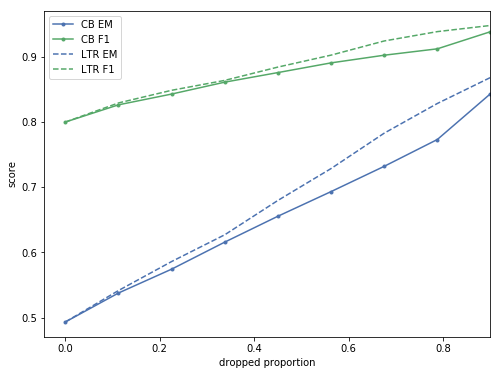

In [181]:
generate_plot(reject_conf_accu_val_model, conf_accu_val_config)

pred-predict-Accuracy, train on val

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


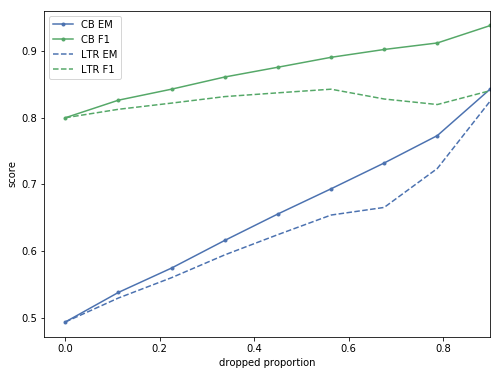

In [182]:
generate_plot(reject_pred_accu_val_model, pred_accu_val_config)

conf-predict-Accuracy, train on train

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


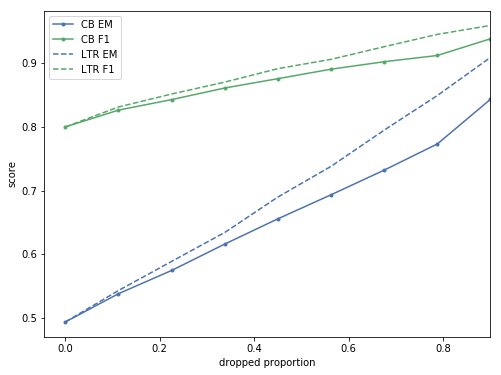

In [183]:
generate_plot(reject_conf_accu_train_model, conf_accu_train_config)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


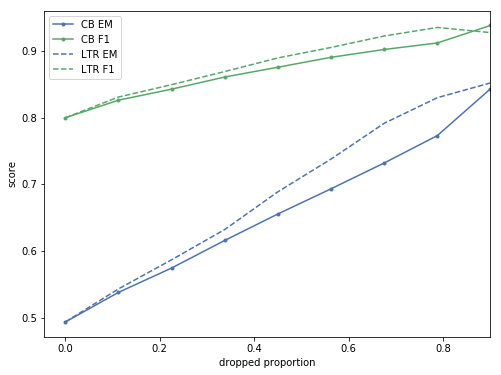

In [184]:
generate_plot(reject_conf_loss_train_model, conf_loss_train_config)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


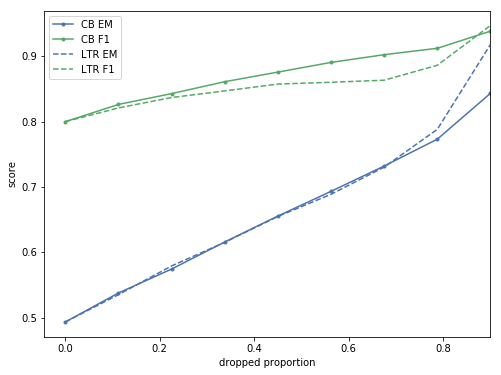

In [185]:
generate_plot(reject_pred_loss_train_model, pred_loss_train_config)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


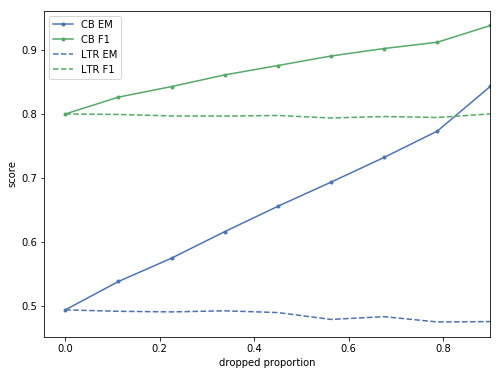

In [186]:
generate_plot(reject_h_loss_train_model, h_loss_train_config)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


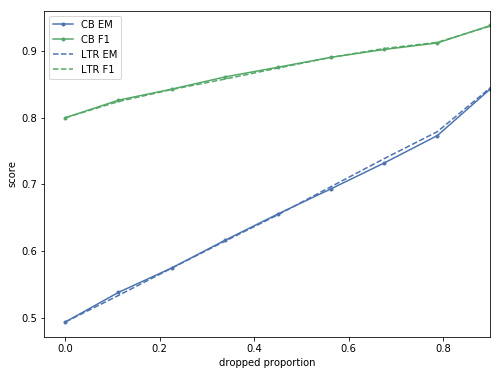

In [187]:
generate_plot(reject_logit_loss_train_model, logit_loss_train_config)

## Multi-panel Plot for Paper

Here we generate multi-panel comparison plots for the paper.

Collect first panel of 4 figures:
all of them will be trained on training set

1. conf - accu / loss
2. pred - accu / loss
3. logit - accu / loss
4. h - accu / loss

In [188]:
def train_model(config, epochs=3, return_pairs=False):
    model, op = loss_reset_all(config)
    loss_list, exp_loss_list, obj_pred_true_pairs = loss_train_epochs(epochs, model, op, config)
    if return_pairs:
        return model, obj_pred_true_pairs
    return model

In [189]:
conf_accu_config = Config(obj_accu=True, 
                obj_loss=False,
                inp_logit=False, 
                inp_pred=False,
                inp_h=False, 
                inp_conf=True,
                train_on_train=True)
conf_accu_model = train_model(conf_accu_config)
conf_loss_config = Config(obj_accu=False, 
                obj_loss=True,
                inp_logit=False, 
                inp_pred=False,
                inp_h=False, 
                inp_conf=True,
                train_on_train=True)
conf_loss_model = train_model(conf_loss_config)
pred_accu_config = Config(obj_accu=True, 
                obj_loss=False,
                inp_logit=False, 
                inp_pred=True,
                inp_h=False, 
                inp_conf=False,
                train_on_train=True)
pred_accu_model = train_model(pred_accu_config)
pred_loss_config = Config(obj_accu=False, 
                obj_loss=True,
                inp_logit=False, 
                inp_pred=True,
                inp_h=False, 
                inp_conf=False,
                train_on_train=True)
pred_loss_model = train_model(pred_loss_config)
logit_accu_config = Config(obj_accu=True, 
                obj_loss=False,
                inp_logit=True, 
                inp_pred=False,
                inp_h=False, 
                inp_conf=False,
                train_on_train=True)
logit_accu_model = train_model(logit_accu_config)
logit_loss_config = Config(obj_accu=False, 
                obj_loss=True,
                inp_logit=True, 
                inp_pred=False,
                inp_h=False, 
                inp_conf=False,
                train_on_train=True)
logit_loss_model = train_model(logit_loss_config)
h_accu_config = Config(obj_accu=True, 
                obj_loss=False,
                inp_logit=False, 
                inp_pred=False,
                inp_h=True, 
                inp_conf=False,
                train_on_train=True)
h_accu_model = train_model(h_accu_config)
h_loss_config = Config(obj_accu=False, 
                obj_loss=True,
                inp_logit=False, 
                inp_pred=False,
                inp_h=True, 
                inp_conf=False,
                train_on_train=True)
h_loss_model = train_model(h_loss_config)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:72: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:79: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:88: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:81: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 1 finished
Epoch 2 finished
Epoch 3 finished
Epoch 1 finished
Epoch 2 finished
Epoch 3 finished
Epoch 1 finished
Epoch 2 finished
Epoch 3 finished
Epoch 1 finished
Epoch 2 finished
Epoch 3 finished
Epoch 1 finished
Epoch 2 finished
Epoch 3 finished
Epoch 1 finished
Epoch 2 finished
Epoch 3 finished
Epoch 1 finished
Epoch 2 finished
Epoch 3 finished
Epoch 1 finished
Epoch 2 finished
Epoch 3 finished


In [190]:
def apply_pretty_plot(ax, model_accu, config_accu, model_loss, config_loss, tag='', adobe=False):
    plt.rc("text",usetex=False)
    plt.rc("font",family="sans-serif",size=16)
    plt.rcParams["font.sans-serif"] = 'Arial'
    
    symbols=['-s','-o','-v','-|','-<','->','-v','-^', '-1', '-2']
    
    conf_ems, conf_f1s = get_ems_f1s(model_loss, config_loss, conf_abstention=True, adobe=adobe)
    
    ltr_loss_ems, ltr_loss_f1s = get_ems_f1s(model_loss, config_loss, adobe=adobe)
    ltr_accu_ems, ltr_accu_f1s = get_ems_f1s(model_accu, config_accu, adobe=adobe)
    colors = ['#1f77b4', '#d62728']  # #1F77B4, #FF7F0E
    
    # we also add 2 lines indicating 100% accept ratio value, which 
    # is the baseline trained model

    ax.plot(np.linspace(0., 0.9, num=9), conf_ems, '--', markersize=8, label='CB EM', linewidth=3, c=colors[0])
    ax.plot(np.linspace(0., 0.9, num=9), conf_f1s, '--', markersize=8, label='CB F1', linewidth=3, c=colors[1])
    
    # want to emphasize this one!
    ax.plot(np.linspace(0., 0.9, num=9), ltr_accu_ems, symbols[0], markersize=8, label='LTA {} Accu EM'.format(tag), linewidth=3, c=colors[0])
    ax.plot(np.linspace(0., 0.9, num=9), ltr_accu_f1s, symbols[0], markersize=8, label='LTA {} Accu F1'.format(tag), linewidth=3, c=colors[1])

    ax.plot(np.linspace(0., 0.9, num=9), ltr_loss_ems, symbols[1], markersize=8, label='LTA {} Loss EM'.format(tag), linewidth=3, c=colors[0])
    ax.plot(np.linspace(0., 0.9, num=9), ltr_loss_f1s, symbols[1], markersize=8, label='LTA {} Loss F1'.format(tag), linewidth=3, c=colors[1])
    

#     ax.xlim(xmax=0.9)
    ax.set_ylabel('Score')
    ax.set_xlabel('Abstention proportion')
    ax.legend(loc="best", prop={'size': 12})  

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


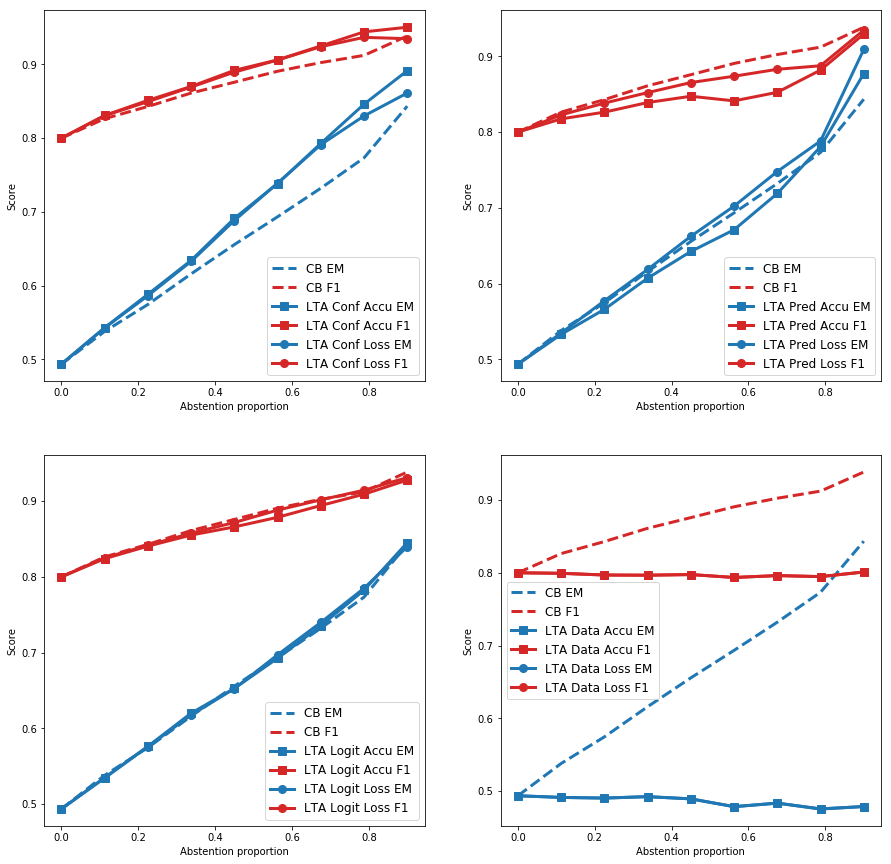

In [191]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 15))  # sharey=True, sharex=True
# f.suptitle('Sharing Y axis')

apply_pretty_plot(ax1, conf_accu_model, conf_accu_config, conf_loss_model, conf_loss_config, tag='Conf')
apply_pretty_plot(ax2, pred_accu_model, pred_accu_config, pred_loss_model, pred_loss_config, tag='Pred')
apply_pretty_plot(ax3, logit_accu_model, logit_accu_config, logit_loss_model, logit_loss_config, tag='Logit')
apply_pretty_plot(ax4, h_accu_model, h_accu_config, h_loss_model, h_loss_config, tag='Data')

In [192]:
f.savefig('2by2abstainsion'+".pdf",format='pdf', bbox_inches='tight')

/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


In the last graph we compare the best lines from 2 plots, and see whichever one is the best

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


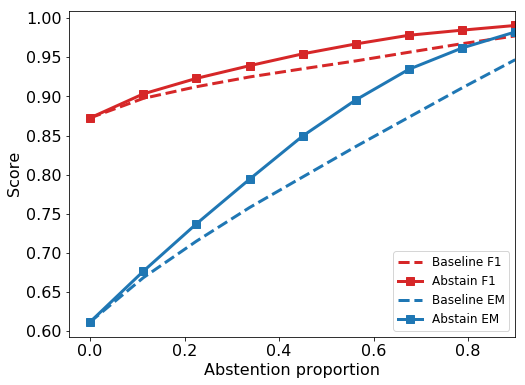

In [231]:
conf_ems, conf_f1s = get_ems_f1s(conf_accu_model, conf_accu_config, conf_abstention=True, adobe=False)
ltr_conf_accu_ems, ltr_conf_accu_f1s = get_ems_f1s(conf_accu_model, conf_accu_config)
# ltr_pred_loss_ems, ltr_pred_loss_f1s = get_ems_f1s(pred_loss_model, pred_loss_config)

# we also add 2 lines indicating 100% accept ratio value, which 
# is the baseline trained model

symbols=['-s','-o','-v','-|','-<','->','-v','-^', '-1', '-2']

fig = plt.figure(0, figsize=(8, 6))

colors = ['#1f77b4', '#d62728']

plt.plot(np.linspace(0., 0.9, num=9), conf_f1s, '--', markersize=8, label='Baseline F1', linewidth=3, c=colors[1])
plt.plot(np.linspace(0., 0.9, num=9), ltr_conf_accu_f1s, symbols[0], markersize=8, label='Abstain F1', linewidth=3, c=colors[1]) # LTA Conf Accu
# plt.plot(np.linspace(0., 0.9, num=9), ltr_pred_loss_f1s, symbols[1], markersize=8, label='LTA Pred Loss F1', linewidth=3, c=colors[1])


plt.plot(np.linspace(0., 0.9, num=9), conf_ems, '--', markersize=8, label='Baseline EM', linewidth=3, c=colors[0]) # CB
plt.plot(np.linspace(0., 0.9, num=9), ltr_conf_accu_ems, symbols[0], markersize=8, label='Abstain EM', linewidth=3, c=colors[0]) #LTA Conf Accu
# plt.plot(np.linspace(0., 0.9, num=9), ltr_pred_loss_ems, symbols[1], markersize=8, label='LTA Pred Loss EM', linewidth=3, c=colors[0])


plt.xlim(xmax=0.9)
plt.ylabel('Score')
plt.xlabel('Abstention proportion')
plt.legend(loc="best", prop={'size': 12})  

plt.show()

In [194]:
fig.savefig('best-abstainsion-2'+".pdf",format='pdf', bbox_inches='tight')

/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


We investigate on how well the model does at predicting the objective.

Due to limited time (literally 2-3 hours, we only draw two plots on how well the best 2 models do)

In [195]:
new_conf_accu_config = Config(obj_accu=True, 
                obj_loss=False,
                inp_logit=False, 
                inp_pred=False,
                inp_h=False, 
                inp_conf=True,
                train_on_train=True)
new_conf_accu_model, conf_accu_pairs = train_model(new_conf_accu_config, return_pairs=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:72: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:79: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:88: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:81: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 1 finished
Epoch 2 finished
Epoch 3 finished


In [196]:
new_pred_loss_config = Config(obj_accu=False, 
                obj_loss=True,
                inp_logit=False, 
                inp_pred=True,
                inp_h=False, 
                inp_conf=False,
                train_on_train=True)
new_pred_loss_model, pred_loss_pairs = train_model(new_pred_loss_config, return_pairs=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:72: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:79: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:88: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:81: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 1 finished
Epoch 2 finished
Epoch 3 finished


In [197]:
from sklearn import linear_model
import numpy as np

# xlim=None, ylim=None, xlabel=None, ylabel=None
def generate_scatter_plot_with_trend_lines(ax, pairs, **kwargs):
    obj = [t[0] for t in pairs]
    pred = [t[1] for t in pairs]
    
    regr = linear_model.LinearRegression()

    regr.fit(np.array(pred).reshape(len(pred),1), np.array(obj).reshape(len(pred), 1))
    linear_corr_line = regr.predict(np.array(pred).reshape(len(pred),1))
    
    print("R^2 is: ", metrics.r2_score(obj, pred))
        
    ax.scatter(pred, obj, alpha=0.5)  # , c=colors , s=area
    ax.plot(pred, linear_corr_line, color='red', linewidth=1)
    
    ax.set(**kwargs) # xlim=xlim, ylim=ylim, xlabel="Predicted loss"

R^2 is:  0.2607694138082276
R^2 is:  0.22552410292802982


/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


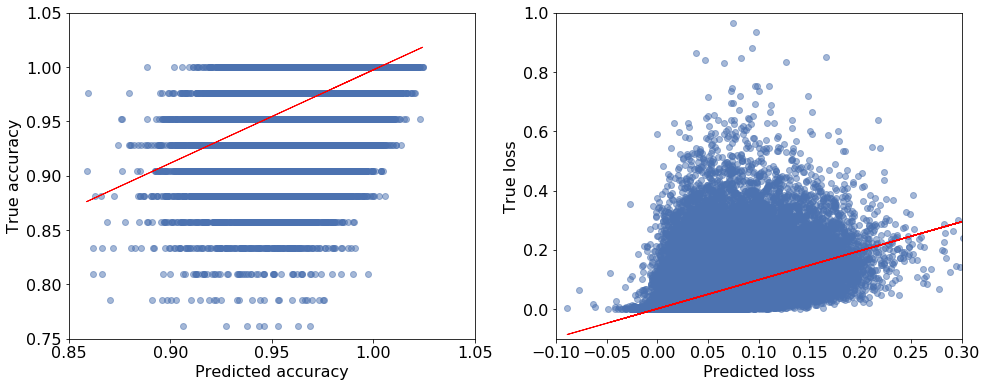

In [198]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

plt.rc("text",usetex=False)
plt.rc("font",family="sans-serif",size=16)
plt.rcParams["font.sans-serif"] = 'Arial'

generate_scatter_plot_with_trend_lines(ax1, conf_accu_pairs, xlim=[0.85, 1.05], 
                                       ylim=[0.75, 1.05], xlabel="Predicted accuracy", ylabel="True accuracy")
generate_scatter_plot_with_trend_lines(ax2, pred_loss_pairs, xlim=[-0.1, 0.3], ylim=[-0.1, 1.0],
                                      xlabel="Predicted loss", ylabel="True loss")

In [199]:
fig.savefig('conf-accu-pred-loss-scatterplot.png', bbox_inches='tight')

/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


## Investigating dropped document

generate a side-by-side plot of the label distribution and number of labels

we set dropped proportion to be 0.3 because we can get meaningful increase without dropping too many documents.

In [200]:
new_h_loss_config = Config(obj_accu=False, 
                obj_loss=True,
                inp_logit=False, 
                inp_pred=False,
                inp_h=True, 
                inp_conf=False,
                train_on_train=True)
new_h_loss_model = train_model(h_loss_config)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:72: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:79: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:88: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:81: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 1 finished
Epoch 2 finished
Epoch 3 finished


In [201]:
h_loss_rej_pred, h_loss_rej_y_labels, em, f1 = drop_portion_evaluate(new_h_loss_model, 0.3, new_h_loss_config, return_dropped=True)
print(em, f1)

0.4945417618684945 0.7980189831825113


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [202]:
rej_pred, rej_y_labels, em, f1 = drop_portion_evaluate(new_conf_accu_model, 0.3, new_conf_accu_config, return_dropped=True)
print(em, f1)

0.6179233307946179 0.8638595875698866


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [203]:
baseline_rej_pred, baseline_rej_y_labels, em, f1 = drop_portion_evaluate(new_conf_accu_model, 0.3, new_conf_accu_config, return_dropped=True, conf_abstention=True)
print(em, f1)

0.6034526529576034 0.8552253170474752


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [204]:
rej_pred[0].nonzero()[0].size

7

In [205]:
rej_y_labels[0].nonzero()[0].size

10

In [206]:
def get_label_nums(rej_y_labels):
    y_label_nums = []
    for i in range(len(rej_y_labels)):
        label_size = rej_y_labels[i].nonzero()[0].size
        y_label_nums.append(label_size)
    y_label_nums = list(filter(lambda a: a > 0, y_label_nums))
    return y_label_nums

In [207]:
y_label_nums = get_label_nums(rej_y_labels)

In [208]:
baseline_y_label_nums = get_label_nums(baseline_rej_y_labels)

In [209]:
h_loss_rej_y_label_nums = get_label_nums(h_loss_rej_y_labels)

In [210]:
no_label_ex = []
def collect_stats(file_name, doc_lengths, label_lengths, label_dist, truncated_label_dist, one_label_type_dist=None):
    # pass in mutable lists
    # truncated_label_dist only for the 
    with open(file_name, 'r', encoding="utf-8") as f:
        for line in f:
            words, labels = line.split('\t')
            doc_lengths.append(len(words.split()))
            labels = labels.split() # [int(l) for l in labels.split()]
            label_lengths.append(len(labels))
            label_dist.extend(labels)
            truncated_labels = [l for l in labels if int(l) >=14 and int(l) < 41]
            truncated_label_dist.extend(truncated_labels)
            if len(labels) == 0:
                no_label_ex.append([words, labels])
            if one_label_type_dist is not None and len(labels) == 1:
                one_label_type_dist.append(labels[0])

csu_doc_lengths = []
csu_label_lengths = []
csu_label_dist = []
csu_truncated_label_dist = []
csu_one_label_type_dist = []

collect_stats('./data/csu/snomed_multi_label_no_des_test.tsv', csu_doc_lengths, csu_label_lengths, csu_label_dist, csu_truncated_label_dist, csu_one_label_type_dist)

csu_label_lengths = list(filter(lambda a: a > 0, csu_label_lengths))

In [211]:
def generate_abstained_histograms(ax, abstained_bin_counts, total_bin_counts):
    print(len(abstained_bin_counts.astype('float')))
    print(len(total_bin_counts.astype('float') - abstained_bin_counts.astype('float')))
    ax.bar(range(10), abstained_bin_counts.astype('float'), color='#FF7F0E', label='Abstained', align='center') # align='center'
    ax.bar(range(10), total_bin_counts.astype('float') - abstained_bin_counts.astype('float'), label='Total', color='#1F77B4',
       bottom=abstained_bin_counts, align='center')
    
    ax.set(xticks=range(10), xlim=[0, 10])
    ax.legend(loc="best", prop={'size': 16})
    ax.set_ylabel('Number of documents')
    ax.set_xlabel('Number of labels in document')

10
10
10
10


/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


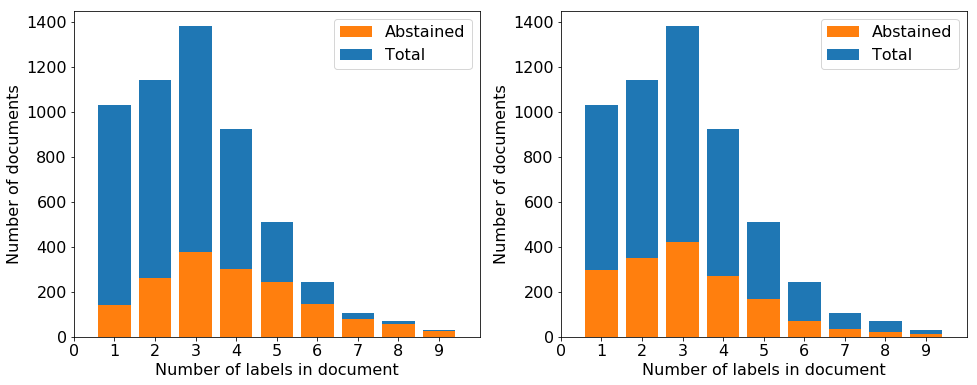

In [212]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

plt.rc("text",usetex=False)
plt.rc("font",family="sans-serif",size=16)
plt.rcParams["font.sans-serif"] = 'Arial'

learned_counts = np.bincount(y_label_nums)[:10]
baseline_counts = np.bincount(baseline_y_label_nums)[:10]
total_counts = np.bincount(csu_label_lengths)[:10]
h_counts = np.bincount(h_loss_rej_y_label_nums)[:10]

generate_abstained_histograms(ax1, learned_counts, total_counts)
generate_abstained_histograms(ax2, h_counts, total_counts)

Text(0.5,0,'Number of labels in document')

/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


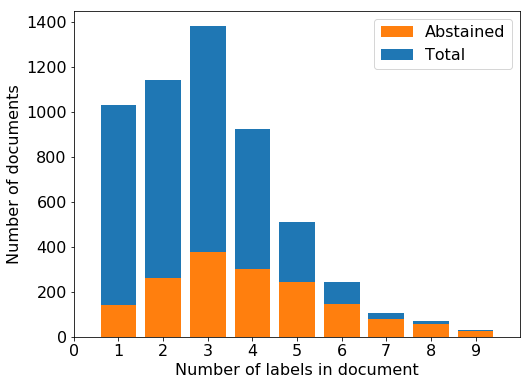

In [213]:
fig = plt.figure(0, figsize=(8, 6))

# Yuhui: what is csu_counts? I set it to 10
plt.bar(range(10), learned_counts.astype('float'), color='#FF7F0E', label='Abstained', align='center') # align='center'
plt.bar(range(10), total_counts.astype('float') - learned_counts.astype('float'), label='Total', color='#1F77B4',
   bottom=learned_counts, align='center')

plt.xticks(range(10))
plt.xlim([0, 10])
plt.legend(loc="best", prop={'size': 16})
plt.ylabel('Number of documents')
plt.xlabel('Number of labels in document')

In [214]:
fig.savefig('number-of-labels-abstained.png', bbox_inches='tight')

/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


In [215]:
h_counts

array([  0, 299, 349, 420, 269, 168,  70,  33,  20,  13])

In [216]:
learned_counts

array([  0, 142, 263, 376, 303, 242, 147,  77,  56,  26])

## Validating on Adobe

So after training and evaluating on CSU data, we can see how well those methods perform in practice: trying out on Adobe data.

1. We get 4 plots first, then generate the single plot, put both in the paper
2. Generate the dropped examples their label distribution and number of labels associated with that document

For now since this is not a good result, we skip it.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


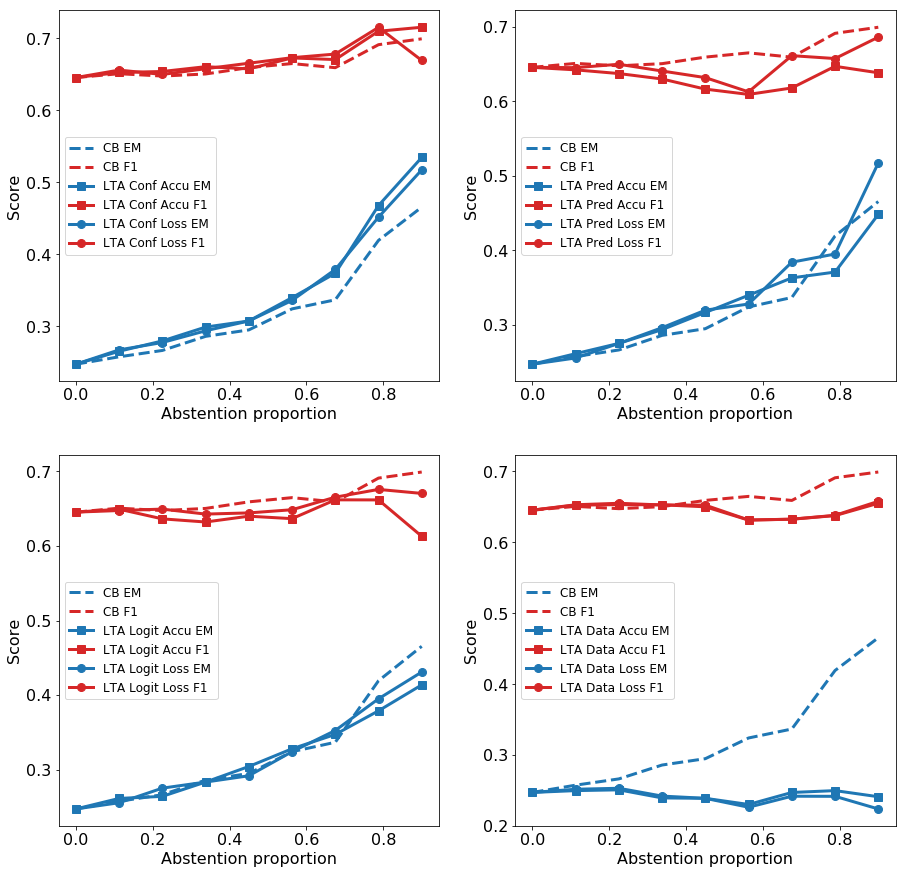

In [217]:
# models are trained already
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 15))  # sharey=True, sharex=True
# f.suptitle('Sharing Y axis')

apply_pretty_plot(ax1, conf_accu_model, conf_accu_config, conf_loss_model, conf_loss_config, tag='Conf', adobe=True)
apply_pretty_plot(ax2, pred_accu_model, pred_accu_config, pred_loss_model, pred_loss_config, tag='Pred', adobe=True)
apply_pretty_plot(ax3, logit_accu_model, logit_accu_config, logit_loss_model, logit_loss_config, tag='Logit', adobe=True)
apply_pretty_plot(ax4, h_accu_model, h_accu_config, h_loss_model, h_loss_config, tag='Data', adobe=True)

## DeepTag-C

Generate the abstention improvement curve over DeepTag

In [218]:
with open('/home/anie/clingendb/csu_avg_5/mod_sigma_W_0001_c_True_sigma_M_00001_sigma_B_0001_avg_run_times_5_bidir_True/train_data.json', 'rb') as f:
    train_data = json.load(f)

In [219]:
with open('/home/anie/clingendb/csu_avg_5/mod_sigma_W_0001_c_True_sigma_M_00001_sigma_B_0001_avg_run_times_5_bidir_True/test_data.json', 'rb') as f:
    test_data = json.load(f)

In [220]:
batched_x_list, batched_y_list, batched_y_hat_list, batched_loss_list = train_data
batched_test_x_list, batched_test_y_list, batched_test_y_hat_list, batched_test_loss_list = test_data

In [221]:
batched_x_tensor_list = list_to_tensor(batched_x_list)
batched_y_tensor_list = list_to_tensor(batched_y_list)
batched_y_hat_tensor_list = list_to_tensor(batched_y_hat_list)
batched_loss_tensor_list = list_to_tensor(batched_loss_list)

In [222]:
batched_test_x_tensor_list = list_to_tensor(batched_test_x_list)
batched_test_y_tensor_list = list_to_tensor(batched_test_y_list)
batched_test_y_hat_tensor_list = list_to_tensor(batched_test_y_hat_list)
batched_test_loss_tensor_list = list_to_tensor(batched_test_loss_list)

In [223]:
# you can tune this model more! and see what works and what doesn't
conf_accu_val_config = Config(obj_accu=True, 
                obj_loss=False,
                inp_logit=False, 
                inp_pred=False,
                inp_h=False, 
                inp_conf=True,
                train_on_val=True,
                train_on_train=False, 
                clip_grad=5.,
                no_shrink=True)
epochs = 2
reject_conf_accu_val_model, rej_conf_accu_val_optimizer = loss_reset_all(conf_accu_val_config)
loss_list, exp_loss_list, obj_pred_true_pairs = loss_train_epochs(epochs, 
                                                                  reject_conf_accu_val_model, 
                                                                  rej_conf_accu_val_optimizer, conf_accu_val_config)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:72: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:79: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:88: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:81: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 1 finished
Epoch 2 finished


/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


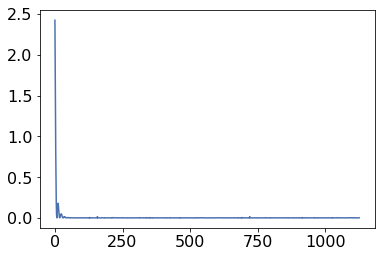

In [224]:
plt.plot(loss_list)

In [225]:
obj_pred_true_pairs[10]

(1.0, 0.9463650584220886)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:72: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:79: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:88: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:81: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 1 finished
Epoch 2 finished
Epoch 1 finished
Epoch 2 finished
Epoch 1 finished
Epoch 2 finished
Epoch 1 finished
Epoch 2 finished
Epoch 1 finished
Epoch 2 finished
Epoch 1 finished
Epoch 2 finished
Epoch 1 finished
Epoch 2 finished
Epoch 1 finished
Epoch 2 finished


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


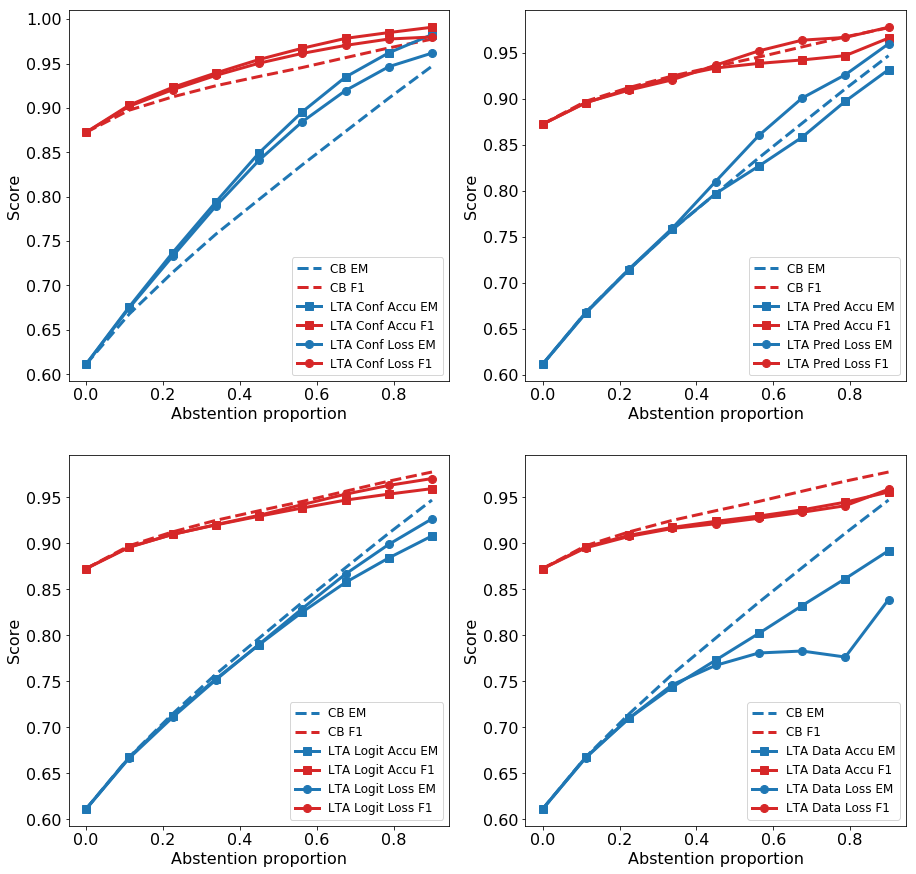

In [226]:
# we use this function to create an internal enviornment so it's not affecting global things
conf_accu_config = Config(obj_accu=True, 
                obj_loss=False,
                inp_logit=False, 
                inp_pred=False,
                inp_h=False, 
                inp_conf=True,
                train_on_train=True)
conf_accu_model = train_model(conf_accu_config, epochs=2)
conf_loss_config = Config(obj_accu=False, 
                obj_loss=True,
                inp_logit=False, 
                inp_pred=False,
                inp_h=False, 
                inp_conf=True,
                reduce_loss=True,  # reduce loss on the second dimension!
                train_on_train=True)
conf_loss_model = train_model(conf_loss_config, epochs=2)
pred_accu_config = Config(obj_accu=True, 
                obj_loss=False,
                inp_logit=False, 
                inp_pred=True,
                inp_h=False, 
                inp_conf=False,
                train_on_train=True)
pred_accu_model = train_model(pred_accu_config, epochs=2)
pred_loss_config = Config(obj_accu=False, 
                obj_loss=True,
                inp_logit=False, 
                inp_pred=True,
                inp_h=False, 
                inp_conf=False,
                reduce_loss=True,
                train_on_train=True)
pred_loss_model = train_model(pred_loss_config, epochs=2)
logit_accu_config = Config(obj_accu=True, 
                obj_loss=False,
                inp_logit=True, 
                inp_pred=False,
                inp_h=False, 
                inp_conf=False,
                train_on_train=True)
logit_accu_model = train_model(logit_accu_config, epochs=2)
logit_loss_config = Config(obj_accu=False, 
                obj_loss=True,
                inp_logit=True, 
                inp_pred=False,
                inp_h=False, 
                inp_conf=False,
                reduce_loss=True,
                train_on_train=True)
logit_loss_model = train_model(logit_loss_config, epochs=2)
h_accu_config = Config(obj_accu=True, 
                obj_loss=False,
                inp_logit=False, 
                inp_pred=False,
                inp_h=True, 
                inp_conf=False,
                train_on_train=True)
h_accu_model = train_model(h_accu_config, epochs=2)
h_loss_config = Config(obj_accu=False, 
                obj_loss=True,
                inp_logit=False, 
                inp_pred=False,
                inp_h=True, 
                inp_conf=False,
                reduce_loss=True,
                train_on_train=True)
h_loss_model = train_model(h_loss_config, epochs=2)

# models are trained already
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 15))  # sharey=True, sharex=True
# f.suptitle('Sharing Y axis')

apply_pretty_plot(ax1, conf_accu_model, conf_accu_config, conf_loss_model, conf_loss_config, tag='Conf', adobe=False)
apply_pretty_plot(ax2, pred_accu_model, pred_accu_config, pred_loss_model, pred_loss_config, tag='Pred', adobe=False)
apply_pretty_plot(ax3, logit_accu_model, logit_accu_config, logit_loss_model, logit_loss_config, tag='Logit', adobe=False)
apply_pretty_plot(ax4, h_accu_model, h_accu_config, h_loss_model, h_loss_config, tag='Data', adobe=False)

In [227]:
f.savefig('2by2abstainsion-deeptag'+".pdf",format='pdf', bbox_inches='tight')

/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


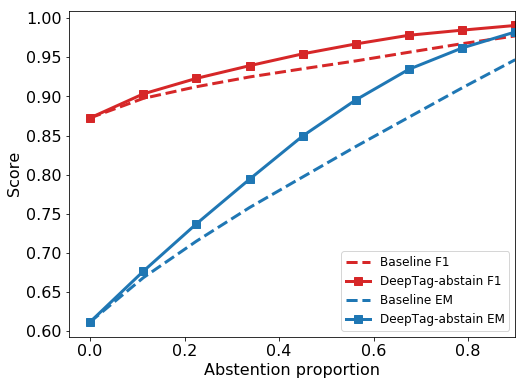

In [228]:
conf_ems, conf_f1s = get_ems_f1s(conf_accu_model, conf_accu_config, conf_abstention=True, adobe=False)
ltr_conf_accu_ems, ltr_conf_accu_f1s = get_ems_f1s(conf_accu_model, conf_accu_config)
# ltr_pred_loss_ems, ltr_pred_loss_f1s = get_ems_f1s(pred_loss_model, pred_loss_config)

# we also add 2 lines indicating 100% accept ratio value, which 
# is the baseline trained model

symbols=['-s','-o','-v','-|','-<','->','-v','-^', '-1', '-2']

fig = plt.figure(0, figsize=(8, 6))

colors = ['#1f77b4', '#d62728']

plt.plot(np.linspace(0., 0.9, num=9), conf_f1s, '--', markersize=8, label='Baseline F1', linewidth=3, c=colors[1])
plt.plot(np.linspace(0., 0.9, num=9), ltr_conf_accu_f1s, symbols[0], markersize=8, label='DeepTag-abstain F1', linewidth=3, c=colors[1]) # LTA Conf Accu
# plt.plot(np.linspace(0., 0.9, num=9), ltr_pred_loss_f1s, symbols[1], markersize=8, label='LTA Pred Loss F1', linewidth=3, c=colors[1])


plt.plot(np.linspace(0., 0.9, num=9), conf_ems, '--', markersize=8, label='Baseline EM', linewidth=3, c=colors[0]) # CB
plt.plot(np.linspace(0., 0.9, num=9), ltr_conf_accu_ems, symbols[0], markersize=8, label='DeepTag-abstain EM', linewidth=3, c=colors[0]) #LTA Conf Accu
# plt.plot(np.linspace(0., 0.9, num=9), ltr_pred_loss_ems, symbols[1], markersize=8, label='LTA Pred Loss EM', linewidth=3, c=colors[0])


plt.xlim(xmax=0.9)
plt.ylabel('Score')
plt.xlabel('Abstention proportion')
plt.legend(loc="best", prop={'size': 12})  

plt.show()

In [229]:
fig.savefig('best-abstainsion-2-deeptag'+".pdf",format='pdf', bbox_inches='tight')

/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


## Calibration curve

Plot the calibration curve on CSU here (both frequent labels and infreuqnet labels)